In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

In [2]:
df = pd.read_csv('../data/raw/all_crashes.csv')
df.head()

,geom,Num_Occupants,Num_MotorVehicles,Fatalities_calc,SuspectedSeriousInjury_calc,NonMotorist_calc,Aggregated_Non_Motorist_txt,CityTownship,CountyNameTxt,Region,...,LocalCodeTxt,doi_date,doi_time,doi_dow_txtCARTO,HitAndRunInd_txtCARTO,VehicleMakeModelYearTxt_list,VehicleTypeCde_txtCARTO_list,doi_hour_txtCARTO,CrashType,CrashDetail
0,POINT(-93.38856788 45.28870554),7,2,1,1,0,Motorist Only,ANDOVER,ANOKA,Metro,...,25217514,"September 30, 2025",06:59:00 AM,Tuesday,"No, Did not Leave Scene","2022 GMC SIERRA, 2015 UNKNOWN 3000","Pickup, School Bus",6:00 AM - 6:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport
1,POINT(-93.37732941 45.25945286),2,2,0,0,0,Motorist Only,ANDOVER,ANOKA,Metro,...,25217042,"September 30, 2025",02:55:00 PM,Tuesday,"No, Did not Leave Scene","2015 CHEVROLET MALIBU, 2004 CHEVROLET SILVERADO","Passenger Car, Pickup",2:00 PM - 2:59 PM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport
2,POINT(-94.14949353 45.12032389),1,1,0,0,0,Motorist Only,COKATO,WRIGHT,East Central,...,25027310,"September 30, 2025",06:58:00 PM,Tuesday,"No, Did not Leave Scene",2017 CHEVROLET EQUINOX,Sport Utility Vehicle,6:00 PM - 6:59 PM,Non-Collision,Overturn/Rollover
3,POINT(-94.14932826 45.1203201),1,1,0,0,0,Motorist Only,COKATO,WRIGHT,East Central,...,WP25027349,"September 30, 2025",07:20:00 AM,Tuesday,"No, Did not Leave Scene",2017 CHEVROLET BOLT EV,Sport Utility Vehicle,7:00 AM - 7:59 AM,Collision w/ Fixed Object,Standing Tree/Shrubbery
4,POINT(-93.31679869 45.18055865),2,2,0,0,0,Motorist Only,COON RAPIDS,ANOKA,Metro,...,25217663,"September 30, 2025",10:52:00 AM,Tuesday,"No, Did not Leave Scene","2025 TESLA MODEL 3, 2014 BMW 535","Passenger Car, Passenger Car",10:00 AM - 10:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport


In [3]:
from shapely import wkt
from src.preprocessing import generate_grid_tc_metro_area

df['geometry'] = df['geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

grid = generate_grid_tc_metro_area(gdf)
grid.head()

,cell_id,geometry
0,0_0,"POLYGON ((-94.42176 44.54218, -94.41546 44.542..."
1,0_1,"POLYGON ((-94.42166 44.54667, -94.41535 44.546..."
2,0_2,"POLYGON ((-94.42155 44.55116, -94.41525 44.551..."
3,0_3,"POLYGON ((-94.42145 44.55565, -94.41514 44.555..."
4,0_4,"POLYGON ((-94.42135 44.56014, -94.41504 44.560..."


In [4]:
from src.preprocessing import create_cell_day_df

cell_day_df = create_cell_day_df(gdf, grid, '2017-01-01', '2025-01-01')
cell_day_df.head()

,cell_id,date,num_crashes,crash_tomorrow
0,0_0,2017-01-01,0,0
1,0_0,2017-01-02,0,0
2,0_0,2017-01-03,0,0
3,0_0,2017-01-04,0,0
4,0_0,2017-01-05,0,0


In [5]:
cell_day_df.info()
cell_day_df.describe()
print(cell_day_df['num_crashes'].value_counts())
print(cell_day_df['crash_tomorrow'].mean())

<class 'pandas.core.frame.DataFrame'>
Index: 200566080 entries, 0 to 7132118
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cell_id         object        
 1   date            datetime64[ns]
 2   num_crashes     int64         
 3   crash_tomorrow  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ GB
num_crashes
0     200214211
1        337342
2         13040
3          1176
4           222
5            62
6            18
7             5
8             3
10            1
Name: count, dtype: int64
0.001754304616214267


In [6]:
pd.crosstab(cell_day_df['cell_id'], cell_day_df['crash_tomorrow'])



crash_tomorrow,0,1
cell_id,,
0_0,2922,0
0_1,2922,0
0_10,2922,0
0_100,2922,0
0_101,2922,0
...,...,...
9_95,2922,0
9_96,2922,0
9_97,2922,0


<Axes: title={'center': 'Total Crashes by Weekday'}, xlabel='weekday'>

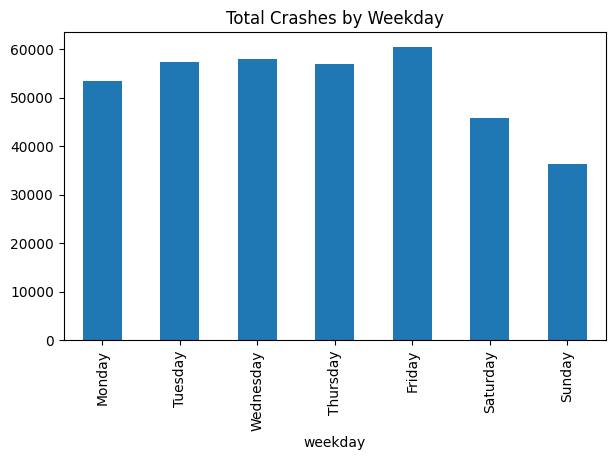

In [7]:
cell_day_df['weekday'] = cell_day_df['date'].dt.day_name()

weekly = cell_day_df.groupby('weekday')['num_crashes'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

weekly.plot(kind='bar', figsize=(7,4), title='Total Crashes by Weekday')

<Axes: title={'center': 'Monthly Crash Totals'}, xlabel='month'>

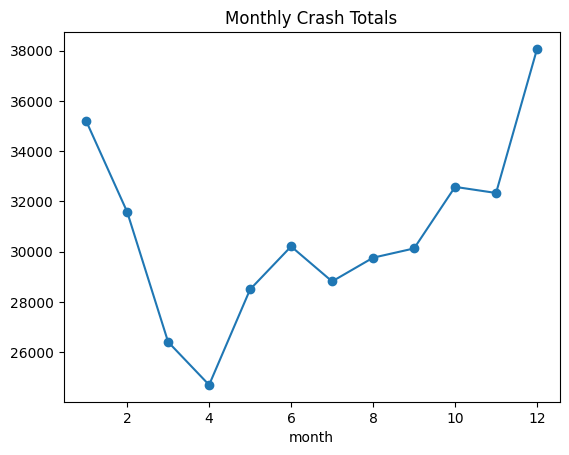

In [8]:
cell_day_df['month'] = cell_day_df['date'].dt.month
monthly = cell_day_df.groupby('month')['num_crashes'].sum()

monthly.plot(kind='line', marker='o', title='Monthly Crash Totals')

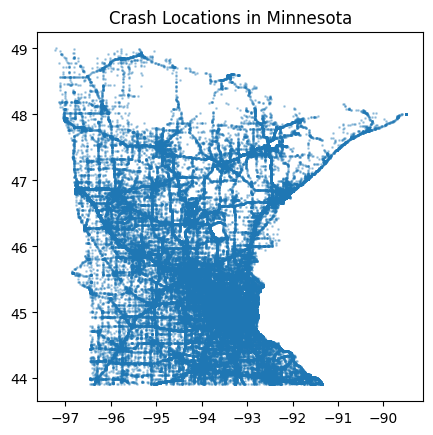

In [9]:
import matplotlib.pyplot as plt

gdf = gpd.GeoDataFrame(df, geometry=df['geometry'], crs='EPSG:4326')

gdf.plot(markersize=1, alpha=0.3)
plt.title("Crash Locations in Minnesota")
plt.show()

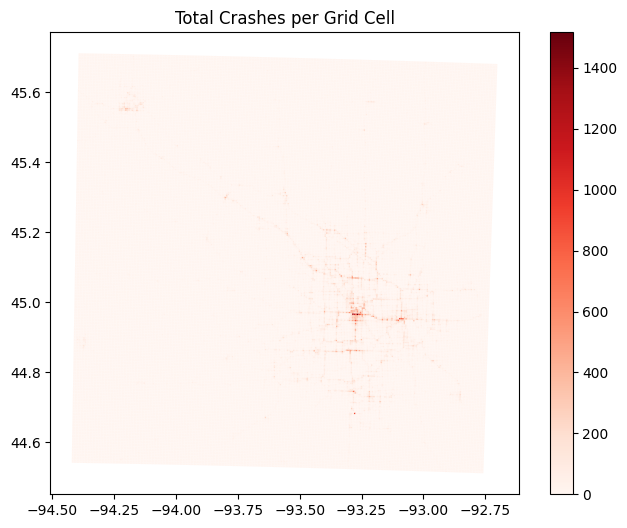

In [10]:
cell_crashes = cell_day_df.groupby('cell_id')['num_crashes'].sum().reset_index()

grid = grid.merge(cell_crashes, on='cell_id', how='left').fillna(0)

grid.plot(column='num_crashes', cmap='Reds', legend=True, figsize=(8,6))
plt.title("Total Crashes per Grid Cell")
plt.show()